# Aula 3 - Técnicas de Seleção de Atributos - parte 2

Na última aula, falamos sobre alguns métodos de seleção de atributos, com maior foco em técnicas de filtro e embutidas. Hoje, vamos finalizar nosso conteúdo de seleção de atributos explorando algumas técnicas de envelopamento ou *wrappers*.

Falaremos sobre:

- *Wrapping*
- Principais técnicas de seleção de atributos por *wrapping*
- Demonstração com *Recursive Feature Elimination*
- Demonstração com Importância de Permutações - *permutation_importance*

## **1. Wrapping**

No método de envelopamento, *wrapping*, diferentes combinações de atributos são testadas em relação à alguma métrica de desempenho, e utilizando-se um modelo de machine learning. Depois do treinamento, o desempenho de todas os modelos treinados com as diferentes combinações de atributos é comparado, e seleciona-se aquela combinação que apresentar o melhor desempenho.

Apesar de utilizar o resultado de modelos, assim como as técnicas de *embedding*, as técnicas *wrapper* realizam a seleção dos atributos **durante o treinamento dos modelos**, enquanto que as técnicas **wrapper** realizam a seleção dos atributos **antes do treinamento iniciar**.

Os métodos mais conhecidos são:

* Forward selection - [SequentialFeatureSelector](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) <br>
* Backward elimination - [SequentialFeatureSelector](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html), [RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE) <br>
* Stepwise selection (Bi-directional elimination) - [SequentialFeatureSelector do mlxtend](http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/#sequentialfeatureselector)<br>
* Permutation Importance - [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html)
<br><br>

### 1.1. **Foward Selection**

Etapas:

1) Começa com um modelo que não contém variáveis (chamado de Null Model)
2) Faz um modelo com cada uma das features separadamente
3) Escolhe a feature mais significativa
4) Roda modelos com a feature selecionada e adicionando mais uma
5) Escolhe o melhor modelo
6) Repete processo 4 e 5 até acabarem as features

<img src="https://quantifyinghealth.com/wp-content/uploads/2019/10/forward-stepwise-algorithm.png" text="https://quantifyinghealth.com/stepwise-selection/" width=400>


<br>

### 1.2. **Backward Selection**

Etapas:

1) Roda um modelo com todas as features
2) Escolhe a feature menos significativa e elimina ela
3) Roda um modelo com as features restantes
4) Repete o processo 2 e 3 sequencialmente

A vantagem do Backward Selection é considerar a interação entre as features antes de eliminá-las, mas se o número de features for muito grande a seleção pode demorar demais.

<br>

 ### 1.3. **Bi-directional Elimination**

Muito semelhante ao Foward selection, mas ao adicionar uma nova variável ele verifica a importantância de todas as features e se encontrar alguma com significância menor que a determinada previamente, remove essa feature específica por meio do Backward Elimination.

Portanto, é uma combinação de seleção para frente e eliminação para trás.

Etapas:

1) Determine um nível de significância para adicionar e remover features do modelo (por exemplo, significancia_add = 0,05 e significancia_remove = 0,05 com 95% de confiança).

2) Execute a próxima etapa do Foward Selection (a feature recém-adicionada deve ter valor p-value < significancia_add para entrar).

3) Execute todas as etapas de eliminação para trás. Ou seja, qualquer recurso adicionado anteriormente com p-value > significancia_remove será removido do modelo).

4) Repita as etapas 2 e 3 até obtermos um conjunto final ótimo de recursos.


Para saber mais acesse o [link 1](https://quantifyinghealth.com/stepwise-selection/) e [link 2](https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/)

## **2. Recursive Feature Elimination**

Conheceremos agora o método **Recursive Feature Elimination** (RFE).

O RFE é um método que se utiliza de um estimador capaz de atribuir um score de **importância** a cada uma das features.

> Por exemplo, podemos olhar para os coeficientes de um modelo linear (`coef_`), ou então, para os scores de importância de features (`feature_importances_`). Esse método só irá funcionar se o estimador escolhido retorna `coef_` ou `feature_importances_`.

O método então considera recursivamente **subconjuntos cada vez menores de features**, da seguinte maneira:

- O estimador é treinado inicialmente com todas as features;
- A importância de cada uma das features é calculada;
- As features menos importantes são retiradas do conjunto de features;
- O processo recomeça, até que o número  desejado de features seja alcançado.

Sendo assim, temos dois hiperparâmetros importantes na classe [RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html):

- `estimator`: o estimador que irá disponibilizar os scores de importância de features;
- `n_features_to_select`: a quantidade de features que o subconjunto final terá.

Na prática, podemos utilizar um gridsearch para otimizar estes dois hiperparâmetros, ou então utilizar a classe [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html), que determina o melhor número de features automaticamente.

<hr>

**Exercício 1** Repita o exercício com o dataset `breast_cancer.csv` usando o algoritmo de LASSO para a seleção dos atributos. Realize a tunagem dos hiperparâmetros do estimador do RFE, do estimador base do AdaBoost e do próprio AdaBoost.

<hr>

In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ignorar warnings
warnings.filterwarnings('ignore')

In [3]:
def metricas_classificacao(estimator, X_train, X_test, y_train, y_test):
    
    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))

    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))

In [4]:
# carregar os dados
data = pd.read_csv('./data/breast_cancer.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
# extraindo preditores e preditos
x = data.drop(['id', 'diagnosis'], axis=1)
y = data[['diagnosis']]

# transformação do target
y.diagnosis = y.diagnosis.map({'M': 1, 'B': 0})

In [6]:
# separar o conjunto de treino e de teste
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.3,
    random_state=2,
    stratify=y
)

In [13]:
# configurar o pipeline do modelo
model_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', RFE(
        estimator=LogisticRegression(penalty='l1', solver='liblinear', random_state=2),
    step=1)),
    ('ada', AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(random_state=2)
    ))
])

# dicionário de parâmetros
params = {
    'feature_selector__n_features_to_select': range(1, x_train.shape[1]+1),
    'feature_selector__estimator__C': np.random.uniform(0.001, 1, 1000),
    'ada__base_estimator__max_depth': range(1, 6),
    'ada__n_estimators': np.random.randint(50, 501, 200)
}

# configura o validador
cvs = StratifiedKFold(n_splits=3, shuffle=True, random_state=2)

# configurar o buscador
search = RandomizedSearchCV(
    estimator=model_pipe,
    cv=cvs,
    param_distributions=params,
    refit=True,
    n_iter=30,
    scoring='f1',
    random_state=2,
    n_jobs=-1
)

# ajustar o modelo
search.fit(x_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=2, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('feature_selector',
                                              RFE(estimator=LogisticRegression(penalty='l1',
                                                                               random_state=2,
                                                                               solver='liblinear'))),
                                             ('ada',
                                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2)))]),
                   n_iter=30, n_jobs=-1,
                   param_distr...
       0.19081509, 0.71885953, 0.24252558, 0.59171065, 0.93272674,
       0.54471256, 0.83238563, 0.56257539, 0.52886854, 0.08831816,
       0.28080957, 0.94606051, 0.23881351, 0.10812324, 0.7045324 ,
       0.52741648, 0.72887762, 0.64

In [15]:
# verificando parâmetros
search.best_params_

{'feature_selector__n_features_to_select': 16,
 'feature_selector__estimator__C': 0.8732172984156308,
 'ada__n_estimators': 174,
 'ada__base_estimator__max_depth': 3}

In [19]:
x_train.shape

(398, 30)


Métricas de avaliação de treino:


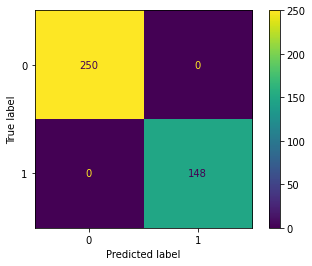

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      1.00      1.00       148

    accuracy                           1.00       398
   macro avg       1.00      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398


Métricas de avaliação de teste:


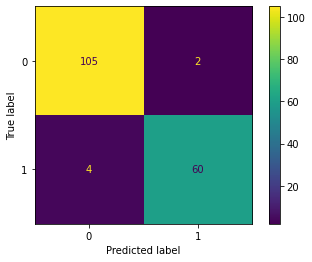

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       107
           1       0.97      0.94      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



In [18]:
# avaliando o modelo
metricas_classificacao(
    estimator=search.best_estimator_,
    X_train=x_train,
    X_test=x_test,
    y_train=y_train,
    y_test=y_test
)

## **3. Importância de Permutações**

este método, utilizamos a função [`sklearn.inspection.permutation_importance()`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html), que vai criar permutações das features, mantendo um registro do score. O permutation_importance é definido como a diminuição no score de um modelo quando uma única feature é embaralhada aleatoriamente. Este procedimento quebra a relação entre a feature e o target e utiliza a queda na pontuação do modelo como um indicativo de quanto o modelo depende dessa feature.

Por realizar diversas permutações, este método é mais custoso, mas tem a vantagem de eliminar o viés que features de alta cardinalidade carregam com o método baseado em impureza.

Para maiores detalhes sobre o método, [clique aqui!](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance)

> Observação: este é um método que pode ser usado com qualquer estimador!

In [21]:
# calculando a importância das permutações usando o melhor AdaBoost encontrado
result_perm = permutation_importance(
    search.best_estimator_,
    x_train,
    y_train,
    n_repeats=30,
    random_state=2
)

In [26]:
# criar um dicionário com a importância média e os desvios padrão
results = {
    'importance': result_perm.importances_mean,
    'std_importance': result_perm.importances_std
}

# criando um dataframe desses resultados
df_import = pd.DataFrame(
    results,
    index=x_train.columns
).sort_values('importance', ascending=False)
df_import

,importance,std_importance
texture_worst,0.021943,0.006646
concavity_worst,0.002094,0.001600
radius_mean,0.000000,0.000000
texture_mean,0.000000,0.000000
symmetry_worst,0.000000,0.000000
concave points_worst,0.000000,0.000000
compactness_worst,0.000000,0.000000
smoothness_worst,0.000000,0.000000
area_worst,0.000000,0.000000
perimeter_worst,0.000000,0.000000


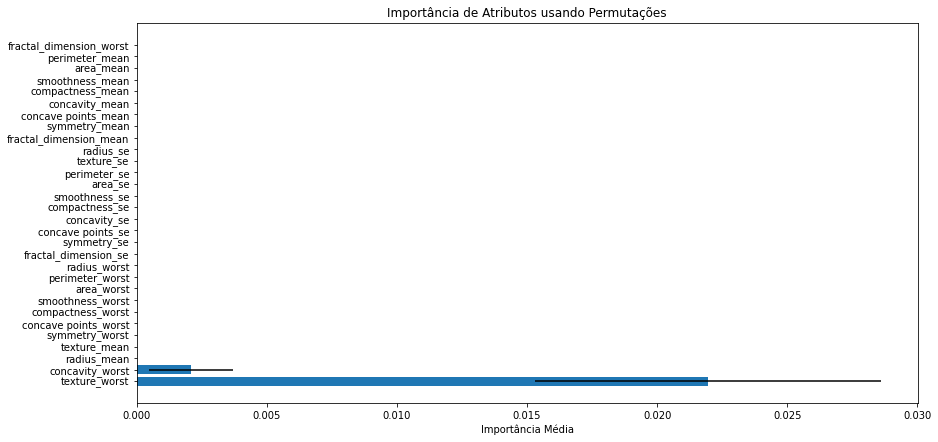

In [29]:
plt.figure(figsize=(14, 7))
plt.title('Importância de Atributos usando Permutações')
plt.barh(df_import.index,
         df_import.importance.values,
         xerr=df_import.std_importance.values)
plt.xlabel('Importância Média')
plt.show()

## **Bibliografia e Aprofundamento**

- [Breve introdução dos métodos supervisionados e não supervisionados de seleção de features](https://www.kdnuggets.com/2021/06/feature-selection-overview.html)
- [Lista de estratégias](https://towardsdatascience.com/feature-selection-a-comprehensive-list-of-strategies-3fecdf802b79)
- [MUITOS métodos diferentes](https://medium.com/analytics-vidhya/feature-selection-extended-overview-b58f1d524c1c)
- [Wrapper methods](https://quantifyinghealth.com/stepwise-selection/)
- [Understanding Bias in RF Variable Importance Metrics](https://blog.methodsconsultants.com/posts/be-aware-of-bias-in-rf-variable-importance-metrics/)
- [Sobre as dificuldades de se interpretar os coeficientes da regressão - Statistical Modeling: The Two Cultures (2001) by Leo Breiman (co-creator of Random Forests)](https://projecteuclid.org/euclid.ss/1009213726)
- [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

<hr>

**Exercício 2** Aplique o conceito do permutation_importances com árvores e com modelos lineares para o dataset `german_credit_data`. O estimador final será um GradientBoosting para ambos os casos.

<hr>